In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk

from statsmodels.graphics.mosaicplot import mosaic

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn import metrics

import ot

import time
import random

In [51]:
original_data = pd.read_csv(
    "adult.csv",
    usecols=[
        "age", "educational-num", "gender", "capital-gain", "capital-loss", "hours-per-week", "income"],
    sep=r'\s*,\s*',
    engine='python',
    na_values="?",
    )

original_data = original_data[["age", "educational-num", "capital-gain", "capital-loss", "hours-per-week", "gender", "income"]]

original_data.head()

,age,educational-num,capital-gain,capital-loss,hours-per-week,gender,income
0,25,7,0,0,40,Male,<=50K
1,38,9,0,0,50,Male,<=50K
2,28,12,0,0,40,Male,>50K
3,44,10,7688,0,40,Male,>50K
4,18,10,0,0,30,Female,<=50K


In [52]:
original_data.tail()

,age,educational-num,capital-gain,capital-loss,hours-per-week,gender,income
48837,27,12,0,0,38,Female,<=50K
48838,40,9,0,0,40,Male,>50K
48839,58,9,0,0,40,Female,<=50K
48840,22,9,0,0,20,Male,<=50K
48841,52,9,15024,0,40,Female,>50K


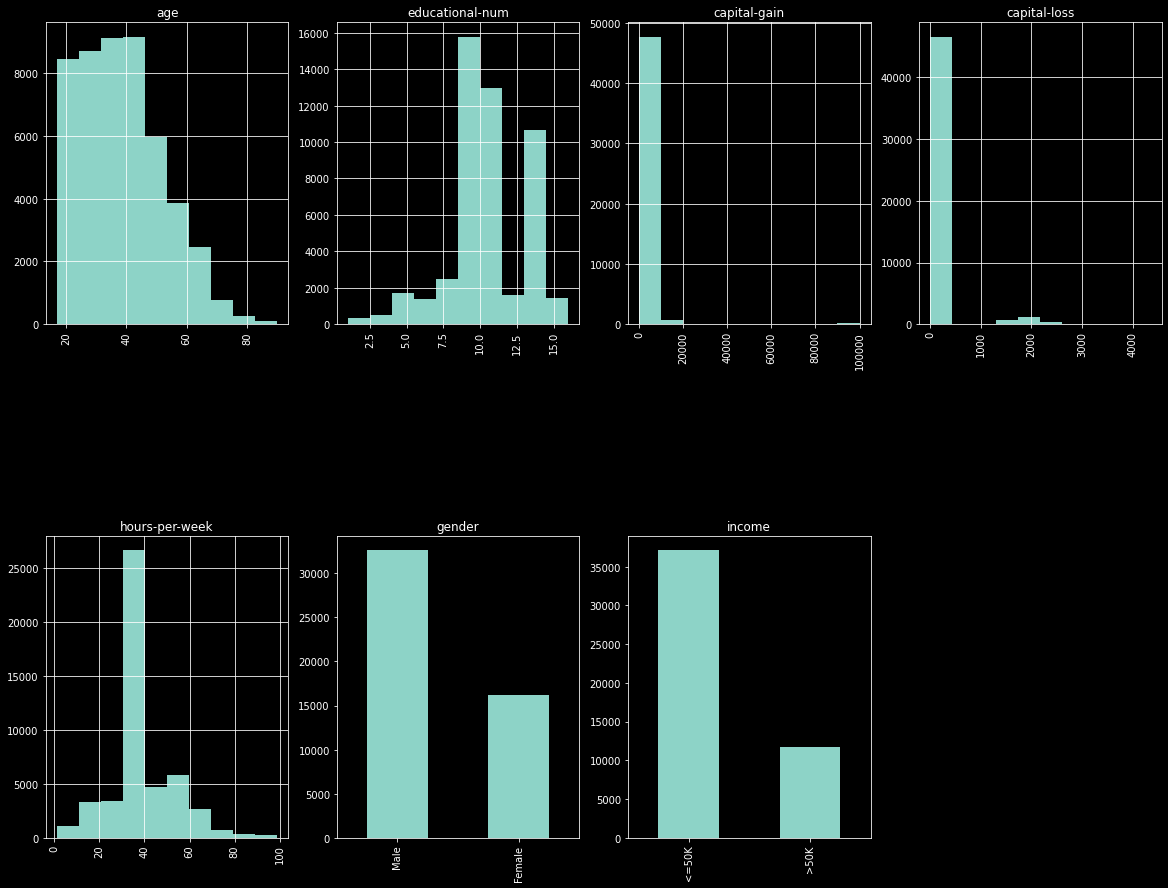

In [53]:
data=original_data.copy()

fig = plt.figure(figsize=(20,15))
cols = 4
rows = int(np.ceil(float(data.shape[1]) / cols))
for i, column in enumerate(data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data.dtypes[column] == object:
        data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

Mosaic plot:


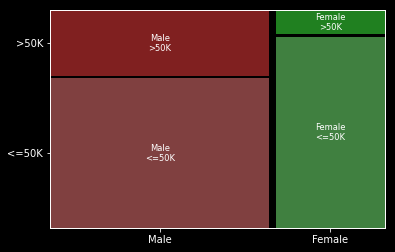

In [54]:
print('Mosaic plot:')

mosaic(data, ['gender','income'],gap=0.02)
plt.savefig('figbias1.pdf')
plt.show()

In [55]:
data_ohe=data.copy()

data_ohe['income'] = np.where(data_ohe['income']=='>50K', 1., 0.)
print('In column Income: >50K gets 1 and <= 50K gets 0')


data_ohe['gender'] = np.where(data_ohe['gender']=='Male', 1., 0.)
print('In column gender: male gets 1 and female gets 0')

data_ohe.tail()

In column Income: >50K gets 1 and <= 50K gets 0
In column gender: male gets 1 and female gets 0


,age,educational-num,capital-gain,capital-loss,hours-per-week,gender,income
48837,27,12,0,0,38,0.0,0.0
48838,40,9,0,0,40,1.0,1.0
48839,58,9,0,0,40,0.0,0.0
48840,22,9,0,0,20,1.0,0.0
48841,52,9,15024,0,40,0.0,1.0


In [62]:
NUMBER_TOTAL = 5000
NUMBER_MALE = 0
NUMBER_FEMALE = 0
LAMBDA = 0

using_data = data_ohe.sample(NUMBER_TOTAL)

for index, row in using_data.iterrows():
    if row['gender'] == 0:
        NUMBER_FEMALE += 1
    else:
        NUMBER_MALE += 1
        
print(f"Total number of samples: {len(using_data)}")
print(f"Number of Male samples: {NUMBER_MALE}")
print(f"Number of Female samples: {NUMBER_FEMALE}")

Total number of samples: 5000
Number of Male samples: 3343
Number of Female samples: 1657


Mosaic plot:


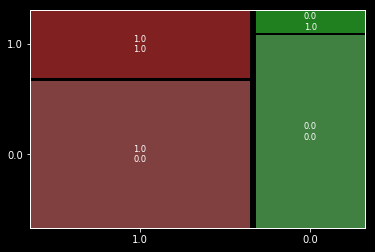

In [63]:
print('Mosaic plot:')

mosaic(using_data, ['gender','income'],gap=0.02)
# plt.savefig('mosaic2.pdf')
plt.show()

In [64]:
y = using_data['income'].values.reshape(-1, 1)
protected_x = using_data['gender'].values.reshape(-1, 1)

using_data_wo_y_gender = using_data.drop(columns=['gender', 'income'])
X_col_names = list(using_data_wo_y_gender.columns)

X_wo_gender = using_data_wo_y_gender.values

print(y.shape, protected_x.shape, X_wo_gender.shape)
print(X_col_names)

(5000, 1) (5000, 1) (5000, 5)
['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [65]:
X_scaled = sk.preprocessing.scale(X_wo_gender)

X  = np.concatenate((X_scaled, protected_x), axis=1)

print(X.shape)

(5000, 6)


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


print('n_train=',X_train.shape[0])
print('n_test=',X_test.shape[0])
print('p=',X_test.shape[1])

NUMBER_TEST = X_test.shape[0]

n_train= 3350
n_test= 1650
p= 6


In [67]:
#instanciate the classifier
before = LogisticRegression(solver='lbfgs',max_iter=10000)

#train the classifier
before.fit(X_train,y_train.ravel())

#predict y_test
y_test_pred_LR=before.predict(X_test)

print('Done Training and Predicting')

Done Training and Predicting


In [68]:
acc=accuracy_score(y_test.ravel(),y_test_pred_LR.ravel())
tpr=np.sum((y_test_pred_LR.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_test_pred_LR.ravel()==1)
tnr=np.sum((y_test_pred_LR.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_test_pred_LR.ravel()==0)

cm = metrics.confusion_matrix(y_test.ravel(),y_test_pred_LR.ravel(),labels=[0,1])

print("\nAccuracy =",acc)
# print("True positive rate =",tpr)  #Rem: Equivalent to metrics.precision_score(y_test.ravel(), y_test_pred.ravel(), pos_label=1.)
# print("True negative rate =",tnr)
# print('\nConfusion matrix =')
# print(cm)


Accuracy = 0.82


In [69]:
count_m = 0
count_f = 0

total_m = 0
total_f = 0

for i in range(NUMBER_TEST):
    if X_test[i][-1] == 1:
        total_m += 1
        if y_test_pred_LR[i] == 1:
            count_m += 1
    else:
        total_f += 1
        if y_test_pred_LR[i] == 1:
            count_f += 1

print(count_m, count_f, total_m, total_f)

232 17 1086 564


In [70]:
prob_s_0 = count_f / total_f
prob_s_1 = count_m / total_m
print(prob_s_0, prob_s_1)
print(f"Disparate impact: {prob_s_0/prob_s_1}")

0.030141843971631204 0.2136279926335175
Disparate impact: 0.14109501100513572


In [71]:
men_X = []
men_Y = []

women_X = []
women_Y = []

for i in range(NUMBER_TOTAL):
    if X[i][-1] == 1:
        men_X.append(X[i])
        men_Y.append(y[i])
    else:
        women_X.append(X[i])
        women_Y.append(y[i])

In [72]:
men_X = np.array(men_X)
men_Y = np.array(men_Y)
women_X = np.array(women_X)
women_Y = np.array(women_Y)

print(men_X.shape, men_Y.shape, women_X.shape, women_Y.shape)

(3343, 6) (3343, 1) (1657, 6) (1657, 1)


In [73]:
cost_matrix = np.zeros((NUMBER_FEMALE, NUMBER_MALE))

In [74]:
for i in range(NUMBER_MALE):
    for j in range(NUMBER_FEMALE):
        dist = 0
        for k in range(6):
            if k == 5:
                continue
            dist = dist + (men_X[i][k] - women_X[j][k])**2
        dist = dist**0.5
        cost_matrix[j][i] = dist

In [75]:
mat_men = np.array([1/NUMBER_MALE] * NUMBER_MALE)
mat_women = np.array([1/NUMBER_FEMALE] * NUMBER_FEMALE)

print(mat_men.shape, mat_women.shape, cost_matrix.shape)

(3343,) (1657,) (1657, 3343)


In [76]:
start = time.time()
ot_emd = ot.emd(mat_women, mat_men, cost_matrix)
time_emd = time.time() - start

print(f"Time taken: {time_emd}")

Time taken: 1.8916504383087158


In [77]:
print(ot_emd.shape)

print(f"sum of first row of transport plan: {sum(ot_emd[0])}")
print(f"Required sum of first row: {1/NUMBER_FEMALE}")

print(sum([sum(ot_emd[i]) for i in range(ot_emd.shape[0])]))

(1657, 3343)
sum of first row of transport plan: 0.0006035003017501509
Required sum of first row: 0.0006035003017501509
1.000000000000012


In [78]:
t_plan = pd.DataFrame(ot_emd)
t_plan.to_csv("Transport_Matrix.csv")

In [79]:
tp = np.copy(ot_emd)

for i in range(NUMBER_FEMALE):
    for j in range(1, NUMBER_MALE):
        tp[i][j] = tp[i][j-1] + tp[i][j]
        
for i in range(NUMBER_FEMALE):
    for j in range(NUMBER_MALE):
        tp[i][j] = tp[i][j] * NUMBER_FEMALE

In [80]:
def get_acc_di(given_data):
    X_after_OT = given_data[:, list(range(6))]
    y_after_ot = given_data[:,6]

    # print(X_after_OT.shape, y_after_ot.shape)
    
    X_train_after_ot, X_test_after_ot, y_train_after_ot, y_test_after_ot = train_test_split(X_after_OT, y_after_ot, test_size=0.33)

    # print('n_train=',X_train_after_ot.shape[0])
    # print('n_test=',X_test_after_ot.shape[0])
    # print('p=',X_test_after_ot.shape[1])

    NUMBER_TEST_AFTER_OT = X_test_after_ot.shape[0]
    
    #instanciate the classifier
    after = LogisticRegression(solver='lbfgs',max_iter=10000)

    #train the classifier
    after.fit(X_train_after_ot,y_train_after_ot.ravel())

    #predict y_test
    y_test_pred_LR=after.predict(X_test_after_ot)

    print('Done Training and Predicting')
    
    acc=accuracy_score(y_test_after_ot.ravel(),y_test_pred_LR.ravel())
    tpr=np.sum((y_test_pred_LR.ravel()==1)*(y_test_after_ot.ravel()==1)) / np.sum(y_test_pred_LR.ravel()==1)
    tnr=np.sum((y_test_pred_LR.ravel()==0)*(y_test_after_ot.ravel()==0)) / np.sum(y_test_pred_LR.ravel()==0)

    cm = metrics.confusion_matrix(y_test_after_ot.ravel(),y_test_pred_LR.ravel(),labels=[0,1])
    
    count_m = 0
    count_f = 0

    total_m = 0
    total_f = 0

    for i in range(NUMBER_TEST_AFTER_OT):
        if X_after_OT[i][-1] == 1:
            total_m += 1
            if y_test_pred_LR[i] == 1:
                count_m += 1
        else:
            total_f += 1
            if y_test_pred_LR[i] == 1:
                count_f += 1

    print(count_m, count_f, total_m, total_f)
    
    prob_s_0 = count_f / total_f
    prob_s_1 = count_m / total_m
    print(prob_s_0, prob_s_1)
    di = prob_s_0/prob_s_1
    print(f"Disparate impact: {di}")
    
    return acc, di

In [94]:
women_X_after_ot = np.copy(women_X)

In [95]:
LAMBDA = 0.8
number_replacements = 0

for i in range(NUMBER_FEMALE):
    s1 = random.uniform(0, 1)
    
    if s1 > LAMBDA:
        continue
    
    number_replacements += 1
    sample = random.uniform(0, 1)
    
    index = 0
    while tp[i][index+1] < sample:
        index += 1
    # print(index)
    for j in range(5):
        women_X_after_ot[i][j] = men_X[index][j]
        
print(f'{LAMBDA} x {NUMBER_FEMALE} = {LAMBDA * NUMBER_FEMALE}')
print(f'Number of replacements = {number_replacements}')

0.8 x 1657 = 1325.6000000000001
Number of replacements = 1333


In [96]:
men_final = np.concatenate((men_X, men_Y), axis=1)
women_final = np.concatenate((women_X_after_ot, women_Y), axis=1)

print(men_final.shape, women_final.shape)

(3343, 7) (1657, 7)


In [97]:
data_after_OT = np.concatenate((men_final, women_final))

print(data_after_OT.shape)

(5000, 7)


In [98]:
np.random.shuffle(data_after_OT)
# print(data_after_OT[:10])


In [99]:
get_acc_di(data_after_OT)

Done Training and Predicting
140 61 1115 535
0.11401869158878504 0.12556053811659193
Disparate impact: 0.9080774365821094


(0.7866666666666666, 0.9080774365821094)

In [100]:
print(0.82 - 0.786)

0.03399999999999992


|             | Accuracy           | Disparate Impact     |
| ----------- | ------------------ | -------------------- |
| Before OT   | 0.82               | 0.14109501100513572  |
| After OT    | 0.7866666666666666 | 0.9080774365821094   |


So, we can see that the accuracy went down by almost 3.3% and the disparate Impact went close to 0.9, which is above to 0.8 (what we need according to 80% rule.).
These are the Values of DI and Accuracy with Lambda = 0.8, i.e. replacing an woman data with corresponding man's data with probability 0.8.